# Import Necessary Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib as mpl
import plotly.express as px
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error , mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

print('Imports Complete')

Imports Complete


# Import the training data

In [2]:
train_df = pd.read_csv('../input/lstm-datasets-multivariate-univariate/LSTM-Multivariate_pollution.csv')
train_df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [3]:
train_df.describe()

,pollution,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


## Lets look at how each numerical column changes over time

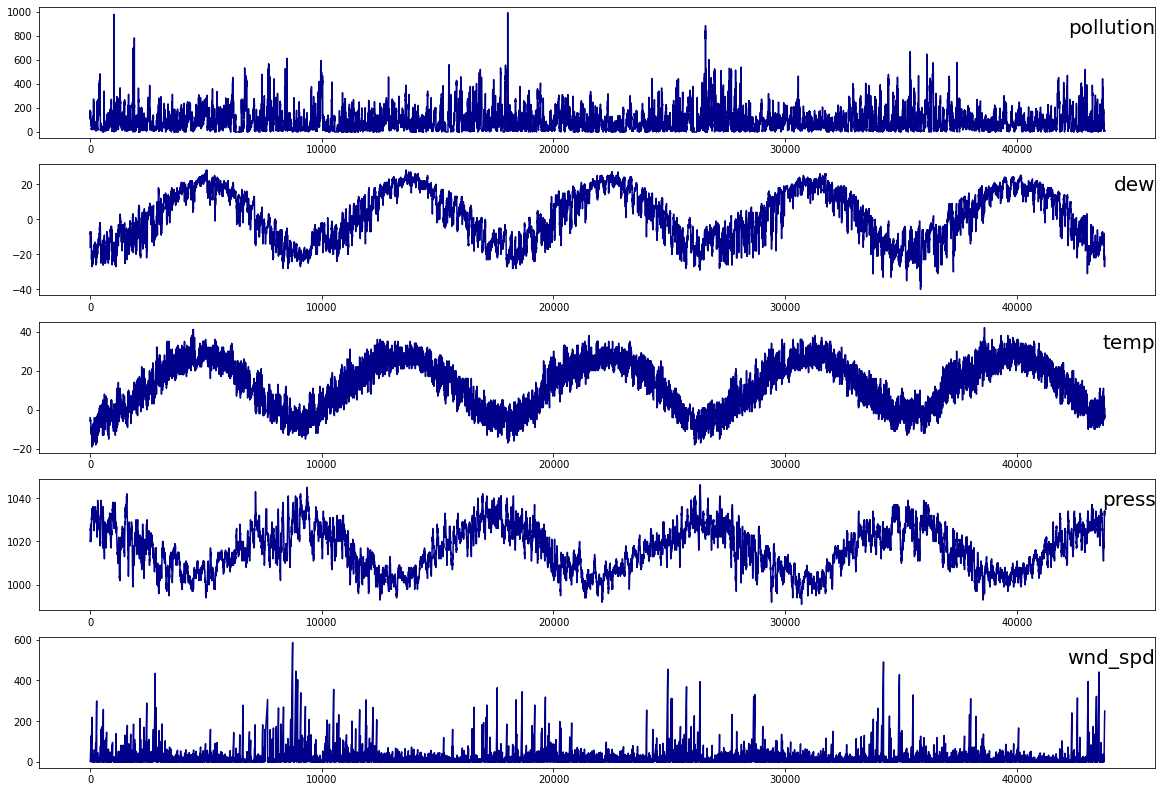

In [4]:
values = train_df.values

# specify columns to plot
groups = [1, 2, 3, 4, 6]
i = 1

# plot each column
plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], c = "darkblue")
    plt.title(train_df.columns[group], y=0.75, loc='right', fontsize = 20)
    i += 1
plt.show()

## Encode Wind direction

In [5]:
train_df.wnd_dir.unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [6]:
def wind_encode(s):
    if s == "SE":
        return 1
    elif s == "NE":
        return 2
    elif s == "NW":
        return 3
    else:
        return 4

train_df["wind_dir"] = train_df["wnd_dir"].apply(wind_encode)
del train_df["wnd_dir"]

In [7]:
train_df.head()

,date,pollution,dew,temp,press,wnd_spd,snow,rain,wind_dir
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,1
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,1
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,1
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,1
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,1


### Scale the data

In [8]:
# Can't scale the date so, I drop it from the dataset

train_df.drop(['date'], inplace=True, axis=1)
train_df.head()

,pollution,dew,temp,press,wnd_spd,snow,rain,wind_dir
0,129.0,-16,-4.0,1020.0,1.79,0,0,1
1,148.0,-15,-4.0,1020.0,2.68,0,0,1
2,159.0,-11,-5.0,1021.0,3.57,0,0,1
3,181.0,-7,-5.0,1022.0,5.36,1,0,1
4,138.0,-7,-5.0,1022.0,6.25,2,0,1


In [9]:
# Now, I can scale the data
scaler= MinMaxScaler()
scaled = scaler.fit_transform(train_df)

In [10]:
scaled = pd.DataFrame(scaled)
scaled.head()

,0,1,2,3,4,5,6,7
0,0.129779,0.352941,0.245902,0.527273,0.002290,0.000000,0.0,0.0
1,0.148893,0.367647,0.245902,0.527273,0.003811,0.000000,0.0,0.0
2,0.159960,0.426471,0.229508,0.545455,0.005332,0.000000,0.0,0.0
3,0.182093,0.485294,0.229508,0.563636,0.008391,0.037037,0.0,0.0
4,0.138833,0.485294,0.229508,0.563636,0.009912,0.074074,0.0,0.0


### This function is from: https://www.kaggle.com/code/sreevaatsavbavana/multivariate-time-series-using-lstms

In [11]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [12]:
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.shape)

(43799, 16)


## Drop excess columns after reframe

In [13]:
# droping columns we don't want to predict

reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.002290   0.000000   
2   0.148893   0.367647   0.245902   0.527273   0.003811   0.000000   
3   0.159960   0.426471   0.229508   0.545455   0.005332   0.000000   
4   0.182093   0.485294   0.229508   0.563636   0.008391   0.037037   
5   0.138833   0.485294   0.229508   0.563636   0.009912   0.074074   

   var7(t-1)  var8(t-1)   var1(t)  
1        0.0        0.0  0.148893  
2        0.0        0.0  0.159960  
3        0.0        0.0  0.182093  
4        0.0        0.0  0.138833  
5        0.0        0.0  0.109658  


## Split the training data into training and validation

- if you do not reshape the data to be 3-dimensional it will throw an error

In [14]:
# each row is 1 hour, so each year is 24 hours * 365 days
year = 24 * 365
values = reframed.values

#train on first 3 years and validate w/ rest
train = values[:(3*year), :]
val = values[(3*year):, :]

# split training and validation into features and target
X_train, y_train = train[:, :-1], train[:, -1]
X_val, y_val = val[:, :-1], val[:, -1]

# reshape input to be 3-dimensional :- (no.of samples, no.of timesteps, no.of features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(26280, 1, 8) (26280,) (17519, 1, 8) (17519,)


In [15]:
train.shape, val.shape, values.shape

((26280, 9), (17519, 9), (43799, 9))

## Lets look at how a simple model performs as a baseline

In [16]:
OPTIMIZER = Adam(learning_rate=0.01)

model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer=OPTIMIZER)

# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_split=0.2, verbose=2, shuffle=False)

2022-09-08 23:33:36.258246: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-09-08 23:33:36.686758: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
292/292 - 3s - loss: 0.0018 - val_loss: 8.1777e-04
Epoch 2/50
292/292 - 1s - loss: 9.3538e-04 - val_loss: 7.1475e-04
Epoch 3/50
292/292 - 1s - loss: 9.2492e-04 - val_loss: 6.9359e-04
Epoch 4/50
292/292 - 1s - loss: 9.3063e-04 - val_loss: 6.8460e-04
Epoch 5/50
292/292 - 1s - loss: 9.4450e-04 - val_loss: 6.8599e-04
Epoch 6/50
292/292 - 1s - loss: 9.5523e-04 - val_loss: 6.8487e-04
Epoch 7/50
292/292 - 1s - loss: 9.5607e-04 - val_loss: 6.7823e-04
Epoch 8/50
292/292 - 1s - loss: 9.5282e-04 - val_loss: 6.6661e-04
Epoch 9/50
292/292 - 1s - loss: 9.4430e-04 - val_loss: 6.5487e-04
Epoch 10/50
292/292 - 1s - loss: 9.3455e-04 - val_loss: 6.4644e-04
Epoch 11/50
292/292 - 1s - loss: 9.2682e-04 - val_loss: 6.4043e-04
Epoch 12/50
292/292 - 1s - loss: 9.2113e-04 - val_loss: 6.3578e-04
Epoch 13/50
292/292 - 1s - loss: 9.1676e-04 - val_loss: 6.3219e-04
Epoch 14/50
292/292 - 1s - loss: 9.1315e-04 - val_loss: 6.2963e-04
Epoch 15/50
292/292 - 1s - loss: 9.1009e-04 - val_loss: 6.2748e-04
Epoch 16

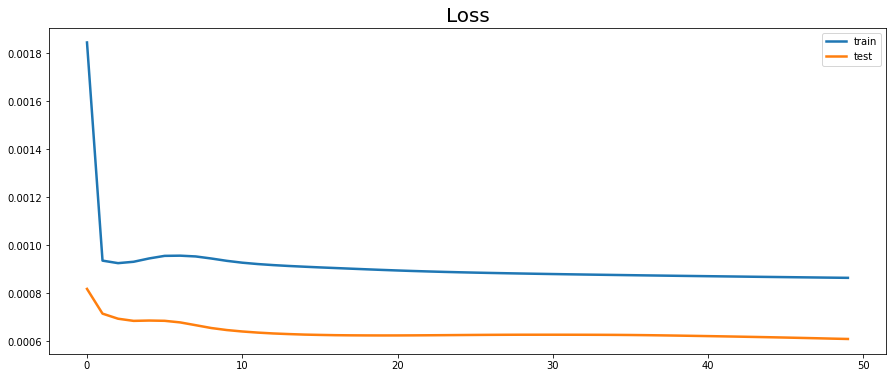

In [17]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.title('Loss', fontsize=20)
plt.legend()
plt.show()

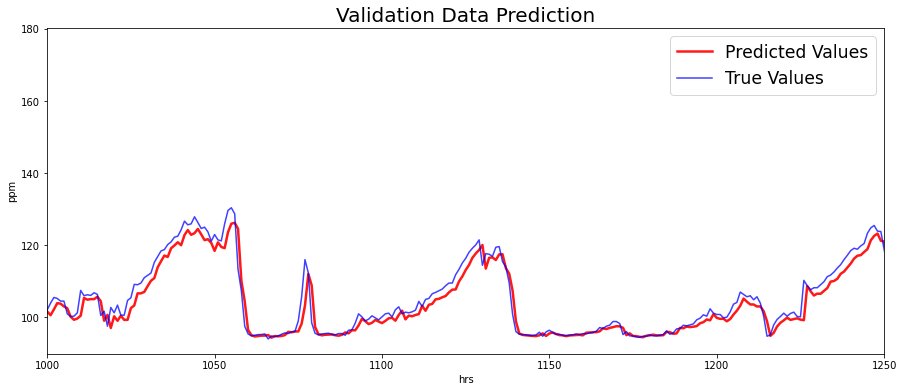

In [18]:
poll = np.array(train_df["pollution"])

poll_mean = poll.mean()
poll_std = poll.std()

y_val_true = val[:,8]
val_pred = model.predict(X_val).ravel()

y_val_true = y_val_true*poll_std + poll_mean
val_pred = val_pred*poll_std + poll_mean
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(val_pred, c = "r", alpha = 0.90, linewidth = 2.5)
plt.plot(y_val_true, c = "b", alpha = 0.75)
plt.title("Validation Data Prediction", fontsize=20)
plt.legend(['Predicted Values', 'True Values'], fontsize='xx-large')
plt.show()


## Let's see how well the model fits the data using the Root Mean Squared Error(RMSE)

**RMSE** shows how far predictions fall from measured true values using Euclidean distance.

In [19]:
rmse = np.sqrt(mean_squared_error(y_val_true, val_pred))
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 2.788203432971394


# Now let's try this again with a more robust model 

**Long Short-Term Memory** (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.

**Dense layer** is the regular deeply connected neural network layer. It is most common and frequently used layer. Dense layer does the below operation on the input and return the output.
```
output = activation(dot(input, kernel) + bias)
```

**Dropout** is a regularization method where input and recurrent connections to LSTM units are probabilistically excluded from activation and weight updates while training a network. This has the effect of reducing overfitting and improving model performance.

**Batch normalization** is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.


In [20]:
model_2 = Sequential()
model_2.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2])))
model_2.add(Dense(200))
model_2.add(Dropout(0.25))
model_2.add(BatchNormalization())
model_2.add(Dense(75))
model_2.add(Dropout(0.1))
model_2.add(BatchNormalization())
model_2.add(Dense(1))
model_2.compile(loss='mse', optimizer=OPTIMIZER)

In [21]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               271360    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               51400     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
dense_2 (Dense)              (None, 75)                15075     
_________________________________________________________________
dropout_1 (Dropout)          (None, 75)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75)               

In [22]:
history_2 = model_2.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_val, y_val), verbose=2, shuffle=True)

Epoch 1/50
206/206 - 5s - loss: 0.5510 - val_loss: 0.0117
Epoch 2/50
206/206 - 2s - loss: 0.0134 - val_loss: 0.0089
Epoch 3/50
206/206 - 2s - loss: 0.0101 - val_loss: 0.0092
Epoch 4/50
206/206 - 2s - loss: 0.0089 - val_loss: 0.0088
Epoch 5/50
206/206 - 2s - loss: 0.0083 - val_loss: 0.0090
Epoch 6/50
206/206 - 2s - loss: 0.0078 - val_loss: 0.0084
Epoch 7/50
206/206 - 2s - loss: 0.0074 - val_loss: 0.0082
Epoch 8/50
206/206 - 2s - loss: 0.0069 - val_loss: 0.0068
Epoch 9/50
206/206 - 2s - loss: 0.0061 - val_loss: 0.0052
Epoch 10/50
206/206 - 2s - loss: 0.0051 - val_loss: 0.0039
Epoch 11/50
206/206 - 3s - loss: 0.0043 - val_loss: 0.0027
Epoch 12/50
206/206 - 2s - loss: 0.0034 - val_loss: 0.0022
Epoch 13/50
206/206 - 2s - loss: 0.0028 - val_loss: 0.0015
Epoch 14/50
206/206 - 2s - loss: 0.0024 - val_loss: 0.0015
Epoch 15/50
206/206 - 2s - loss: 0.0022 - val_loss: 0.0018
Epoch 16/50
206/206 - 2s - loss: 0.0020 - val_loss: 0.0010
Epoch 17/50
206/206 - 2s - loss: 0.0018 - val_loss: 0.0016
Epoch 

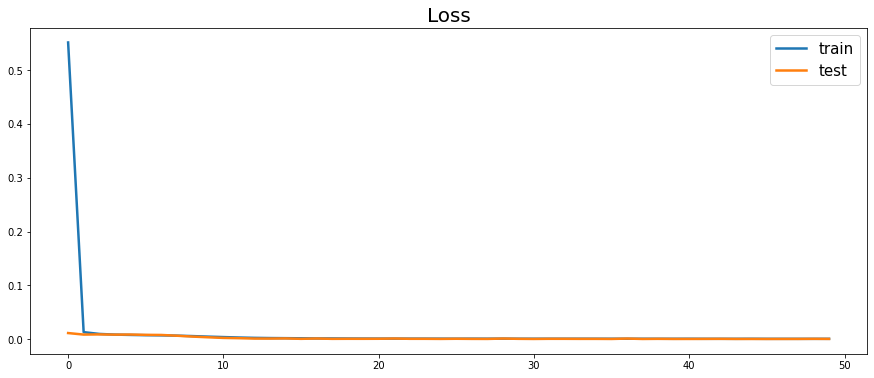

In [23]:
plt.figure(figsize=(15,6))
plt.plot(history_2.history['loss'], label='train', linewidth = 2.5)
plt.plot(history_2.history['val_loss'], label='test',  linewidth = 2.5)
plt.title('Loss', fontsize=20)
plt.legend(fontsize=15)
plt.show()

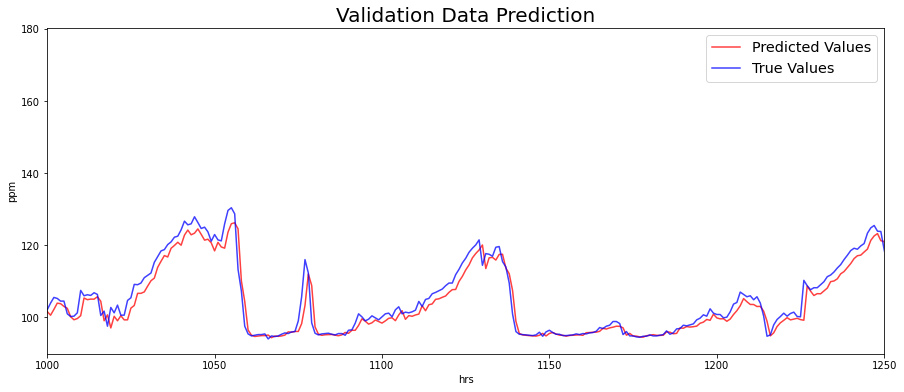

In [24]:
y_val_true = val[:,8]
val_pred2 = model_2.predict(X_val).ravel()

y_val_true = y_val_true*poll_std + poll_mean
val_pred2 = val_pred2*poll_std + poll_mean
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(val_pred, c = "r", alpha = 0.75)
plt.plot(y_val_true, c = "b", alpha = 0.75)
plt.title("Validation Data Prediction", fontsize=20)
plt.legend(['Predicted Values', 'True Values'], fontsize='x-large')
plt.show()


In [25]:
rmse = np.sqrt(mean_squared_error(y_val_true, val_pred2))
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 2.7124656852200904


## Now, lets use the whole training dataset to train and test on the given test set

In [26]:
values.shape

(43799, 9)

In [27]:
values

array([[0.12977867, 0.35294118, 0.24590164, ..., 0.        , 0.        ,
        0.14889336],
       [0.14889336, 0.36764706, 0.24590164, ..., 0.        , 0.        ,
        0.15995976],
       [0.15995976, 0.42647059, 0.2295082 , ..., 0.        , 0.        ,
        0.18209256],
       ...,
       [0.01006036, 0.26470588, 0.26229508, ..., 0.        , 0.66666667,
        0.01006036],
       [0.01006036, 0.26470588, 0.26229508, ..., 0.        , 0.66666667,
        0.00804829],
       [0.00804829, 0.26470588, 0.24590164, ..., 0.        , 0.66666667,
        0.01207243]])

In [28]:
X_train, y_train = values[:, :-1], values[:, -1]
print(X_train.shape, y_train.shape)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
print(X_train.shape[1], X_train[2].shape)

(43799, 8) (43799,)
1 (1, 8)


## To minimize overfitting, I removed some layers from the model

In [29]:
model_3 = Sequential()
model_3.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2])))
model_3.add(Dense(75))
model_3.add(Dropout(0.2))
model_3.add(BatchNormalization())
model_3.add(Dense(10))
model_3.add(Dropout(0.1))
model_3.add(BatchNormalization())
model_3.add(Dense(1))
model_3.compile(loss='mse', optimizer=OPTIMIZER)

In [30]:
history_3 = model_3.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.2, verbose=2, shuffle=True)

Epoch 1/50
137/137 - 5s - loss: 0.1474 - val_loss: 0.0072
Epoch 2/50
137/137 - 2s - loss: 0.0060 - val_loss: 0.0024
Epoch 3/50
137/137 - 2s - loss: 0.0026 - val_loss: 8.3475e-04
Epoch 4/50
137/137 - 2s - loss: 0.0018 - val_loss: 8.2727e-04
Epoch 5/50
137/137 - 2s - loss: 0.0016 - val_loss: 8.5215e-04
Epoch 6/50
137/137 - 2s - loss: 0.0015 - val_loss: 8.1319e-04
Epoch 7/50
137/137 - 2s - loss: 0.0014 - val_loss: 6.4249e-04
Epoch 8/50
137/137 - 2s - loss: 0.0014 - val_loss: 6.6181e-04
Epoch 9/50
137/137 - 2s - loss: 0.0013 - val_loss: 6.1836e-04
Epoch 10/50
137/137 - 2s - loss: 0.0013 - val_loss: 6.0916e-04
Epoch 11/50
137/137 - 2s - loss: 0.0013 - val_loss: 6.5239e-04
Epoch 12/50
137/137 - 3s - loss: 0.0012 - val_loss: 6.0206e-04
Epoch 13/50
137/137 - 2s - loss: 0.0012 - val_loss: 6.0966e-04
Epoch 14/50
137/137 - 2s - loss: 0.0012 - val_loss: 6.0740e-04
Epoch 15/50
137/137 - 2s - loss: 0.0012 - val_loss: 6.2209e-04
Epoch 16/50
137/137 - 2s - loss: 0.0012 - val_loss: 6.0679e-04
Epoch 17/

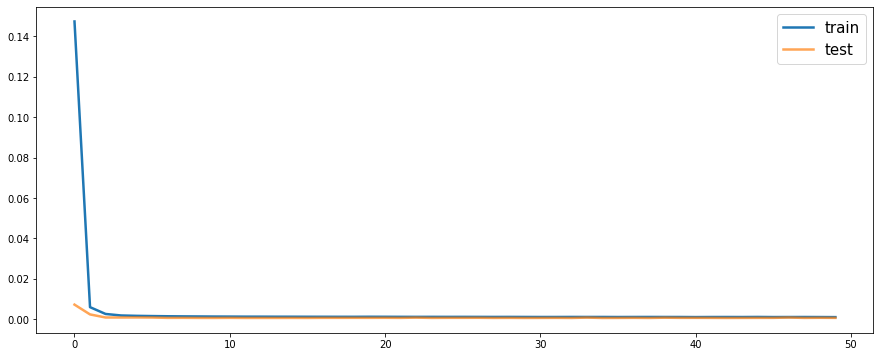

In [31]:
plt.figure(figsize=(15,6))
plt.plot(history_3.history['loss'], label='train', linewidth = 2.5)
plt.plot(history_3.history['val_loss'], label='test', alpha=.7, linewidth = 2.5)
plt.legend(fontsize=15)
plt.show()

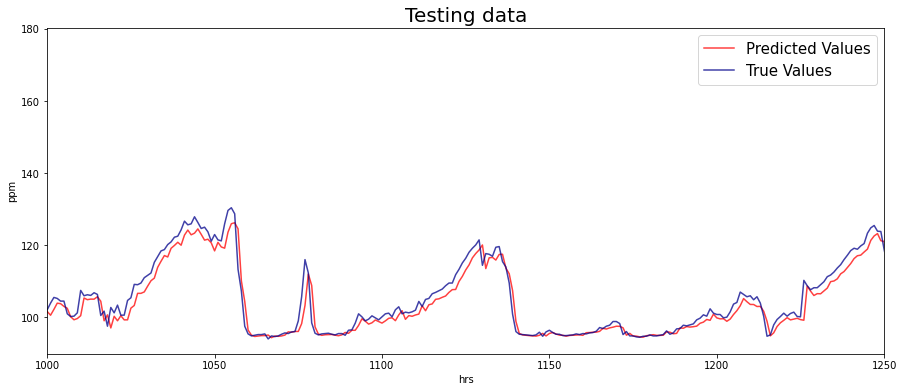

In [32]:
y_val_true = val[:,8]
val_pred3 = model_3.predict(X_val).ravel()

y_val_true = y_val_true*poll_std + poll_mean
val_pred3 = val_pred3*poll_std + poll_mean
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(val_pred, c = "r", alpha = 0.75)
plt.plot(y_val_true, c = "darkblue", alpha = 0.75)
plt.title("Testing data",fontsize=20)
plt.legend(['Predicted Values', 'True Values'], fontsize=15)
plt.show()

In [33]:
rmse = np.sqrt(mean_squared_error(y_val_true, val_pred3))
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 2.541665846815215


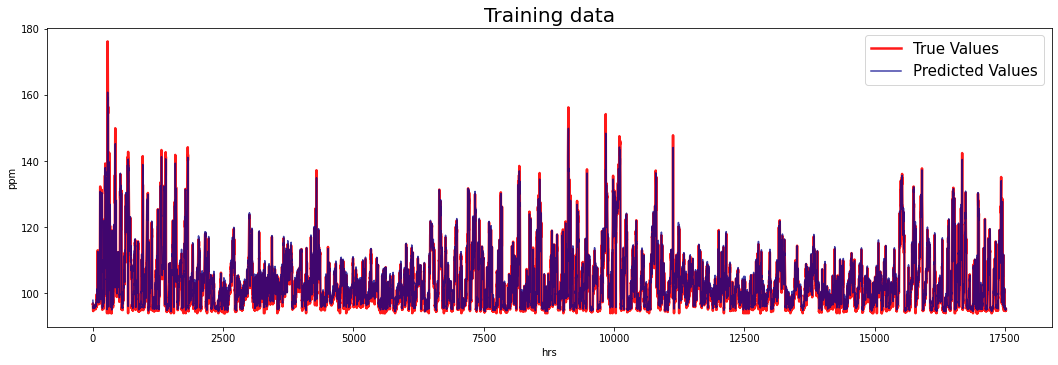

In [34]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,5.5))
# plt.xlim([1000,1250])
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(y_val_true, c = "r", alpha = 0.90, linewidth = 2.5)
plt.plot(val_pred3, c = "darkblue", alpha = 0.75)
plt.title("Training data", fontsize=20)
plt.legend(['True Values', 'Predicted Values'],fontsize=15)
plt.show()

# Import Test data

In [35]:
test_df = pd.read_csv('../input/lstm-datasets-multivariate-univariate/pollution_test_data1.csv')
test_df.head()

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,SE,3.58,0,0,128
1,-17,5,1027,SE,7.60,0,0,77
2,-16,4,1027,SE,9.39,0,0,65
3,-16,1,1028,cv,0.89,0,0,79
4,-14,0,1028,NE,1.79,0,0,93


# Clean the test data
**must** clean exactly like the training data

In [36]:
test_df["wind_dir"] = test_df["wnd_dir"].apply(wind_encode)
del test_df["wnd_dir"]

values_test = test_df.values
values_test = values_test.astype('float32')

scaler1 = MinMaxScaler()
scaled_test = scaler1.fit_transform(values_test)

reframed_test = series_to_supervised(scaled_test, 1, 1)

In [37]:
reframed_test.drop(reframed_test.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

In [38]:
values_test1 = reframed_test.values

test_x, test_y = values_test1[:, :-1], values_test1[:, -1]

test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

val_pred4 = model_3.predict(test_x).ravel()

# Inverse scaling the output, for better visual interpretation 
test_y = test_y*poll_std + poll_mean
val_pred4 = val_pred4*poll_std + poll_mean


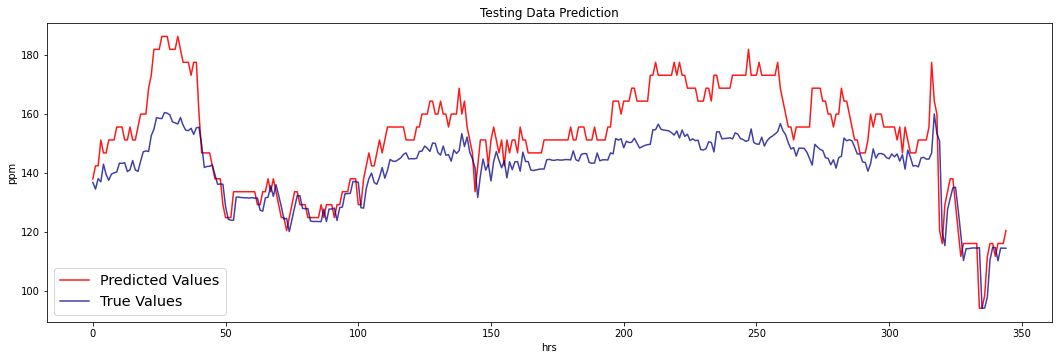

In [39]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,5.5))
plt.ylabel("ppm")
plt.xlabel("hrs")
plt.plot(test_y, c = "r", alpha = 0.90)
plt.plot(val_pred4, c = "darkblue", alpha = 0.75)
plt.title("Testing Data Prediction")
plt.legend(['Predicted Values', 'True Values'], fontsize='x-large')
plt.show()

In [40]:
rmse = np.sqrt(mean_squared_error(test_y, val_pred4))
print("Test RMSE ="  ,rmse)

Test RMSE = 12.90319
